# Coarse graining with CG_Compound class 
Coarse-graining is a technique which provides a computational speed-up in molecular simulation by abstracting away some atomistic detail and thus reducing the degrees of freedom. One example of a coarse-grain model is the united atom model in which hydrogen atoms are treated implicitly and lumped in with with their heavier neighbors. (e.g., a carbon bonded to three hydrogens, $CH_3$, would be treated as one bead; the bending and stretching degrees of freedom between $C-H$ would be lost.) More examples of coarse-grain models and their benefits can be found in our recent [perspective paper](https://doi.org/10.1016/j.commatsci.2019.109129). 

This tutorial will demonstrate how to use SMILES strings and the CG_Compound class to create a coarse-grain structure.

---
**Learning Objectives**
1. Understand the motivation behind using a coarse-grain model.
1. Use smiles strings to select the coarse-grain beads and initialize systems.
1. Prepare a coarse-grain structure for use in molecular simulation.
1. Run and analyze a molecular dynamics simulation.
---

In [1]:
# QtCore, needed for interactive visualization, will open a separate python process
from PySide2 import QtCore

%gui qt

In [2]:
import warnings

import fresnel
import fresnel.interact
import freud
import matplotlib.cm
import mbuild as mb
import numpy as np
import PIL

import utils
from cg_compound import CG_Compound

/Users/jenny/miniconda3/envs/grits/lib/python3.7/site-packages/hoomd/meta.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


A CG_Compound uses [class inheritance](https://docs.python.org/3/tutorial/classes.html#inheritance) to build on to the [mbuild.Compound](https://mosdef.org/mbuild/data_structures.html#compound). This allows us to implement already developed tools! Any mbuild compound can be converted to a CG_Compound using `mbuild.Compound.to_pybel()` (then the `coarse` function) or `CG_Compound.from_mbuild()`. In the following cell, we create a dodecane mbuild compound using only a [SMILES string](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html):

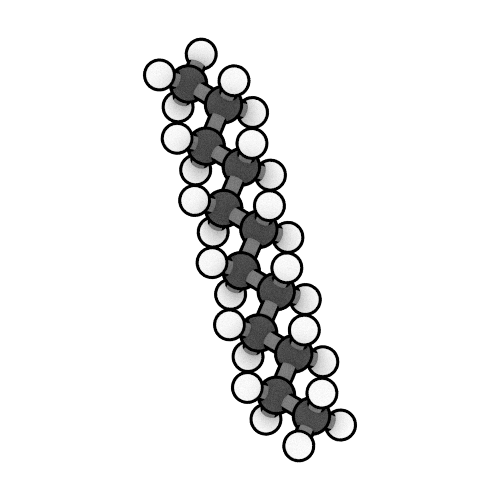

In [4]:
smiles = "CCCCCCCCCCCC"

# openbabel has some annoying, useless warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mb_dodecane = mb.load(smiles, smiles=True)

scene = utils.draw_scene(mb_dodecane)
fresnel.pathtrace(scene, w=500, h=500, light_samples=10)

CG_Compound uses [pybel's SMARTS matching](http://openbabel.org/docs/current/UseTheLibrary/Python_Pybel.html#smarts-matching) to identify the beads based on the provided bead strings. Because neither the mbuild.Compound nor the CG_Compound keep track of the bond order, the bond order update has to be forced after conversion to a pybel mol. 

Then using the `coarse` function, the user can select a SMILES/SMARTS string used to detect the bead and a name for the bead. In this example, the three alkyl carbon SMILES string from the features dictionary generates a coarse-grain structure for nonane, which reduces the 35 atom structure to just 4 beads! 

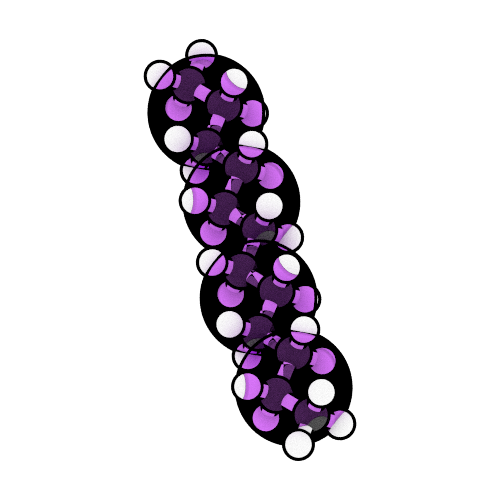

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # convert to pybel mol
    mol = mb_dodecane.to_pybel()

    # to_pybel imports all bonds as order=1, this will type the bond correctly
    # if the structure is good
    mol.OBMol.PerceiveBondOrders()
    
    cg_dodecane = utils.coarse(mol, [("_C3", "CCC")])

# Visualize the compound imposed over the atomistic structure 
# with the show_atomistic flag
scene = utils.draw_scene(cg_dodecane, show_atomistic=True)

# overlay looks better in interactive view
fresnel.pathtrace(scene, w=500, h=500, light_samples=10)

In [8]:
view = fresnel.interact.SceneView(scene)
view.show()

By building on the functionality of mbuild, it is straight-forward to export your coarse-grain structure to any chemical format already supported by mbuild. More about the mbuild.Compound `save` function [here](https://mosdef.org/mbuild/data_structures.html#mbuild.compound.Compound.save).

/Users/jenny/miniconda3/envs/grits/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<_C3 pos=( 0.2055,-0.0244, 0.0414), 0 bonds, id: 4874710864>" is element: "EP"
  atom, element))
/Users/jenny/miniconda3/envs/grits/lib/python3.7/site-packages/numpy/core/numeric.py:2379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


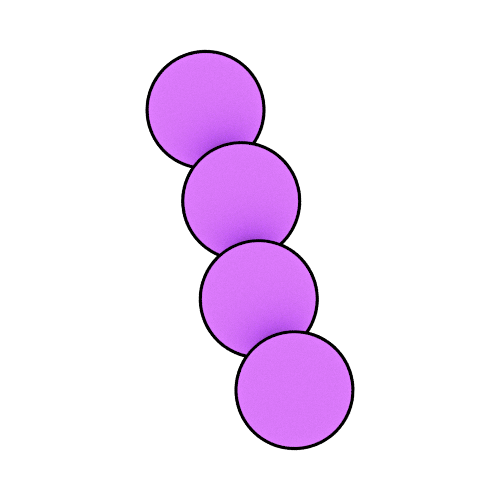

In [9]:
# Save to a file. Other possible extensions include: 
# ‘hoomdxml’, ‘gro’, ‘top’, ‘lammps’, ‘lmp’, ‘json’
cg_dodecane.save("dodecane.gsd", overwrite=True);

# Visualize just the coarse-grained compound, which is what is saved
scene = utils.draw_scene(cg_dodecane)
fresnel.pathtrace(scene, w=500, h=500, light_samples=10)




Try out different coarse-grain mappings! What happens if you use 2, 4 or 6 alkyl carbons?
Replace `YOUR_BEAD_NAME` and `YOUR_SMILES_STRING`:

In [11]:
cg_name = "YOUR_BEAD_NAME"
smiles = "YOUR_SMILES_STRING"

cg_dodecane = utils.coarse(mol, [(cg_name, smiles)])

scene = utils.draw_scene(cg_dodecane, show_atomistic=True)
fresnel.interact.SceneView(scene)

The next example shows how a coarse-grain structure can be mapped to frames of a molecular dynamics trajectory and how to handle some of the issues with coarse-graining arbitrary structures with SMILES strings. This coarse-grain mapping could be the starting point for iterative Boltzmann inversion (IBI): an example IBI code written by McCabe's group at Vanderbilt which implements a multi-state flavor can be found [here](https://github.com/mosdef-hub/msibi). 

The trajectory file (gsd) was created using [PlanckTon](https://bitbucket.org/cmelab/planckton/src/master/) which simplifies the set up and submission of large parameter sweeps by tying together multiple simulation tools.

In [ ]:
# Coordinates are scaled from planckton sigma units
scale_factor = 0.356
comp0 = CG_Compound.from_gsd(gsdfile, frame=0, scale=scale_factor)

# The gsd from PlanckTon was run using the General AMBER Force Field (GAFF)
# and pybel will not correctly parse particles with AMBER typing
comp0.amber_to_element()

# Molecular dynamics simulations in HOOMD use periodic boundary conditions,
# so, in order to identify the beads, the frame must be unwrapped.
# The unwrap feature won't move particles if the compound doesn't have bonds
# that span the periodic boundary -- note the "no changes made" message
comp0.unwrap()

mol0 = comp0.to_pybel(box=comp0.box)

# to_pybel imports all bonds as order=1, this will type the bond correctly
# if the structure is good
mol0.OBMol.PerceiveBondOrders()

In [ ]:
# Notice that the initial frame is typed correctly
# the structure is good so pybel can type it
cg_comp0 = utils.coarse(mol0, 
                        [("_B", "c1sccc1"), 
                         ("_S", "CCC")]
                       )

scene = utils.draw_scene(cg_comp0, show_atomistic=True, show_box=True, color="coolwarm")
fresnel.interact.SceneView(scene)

**The starting structure of the atomistic compound matters!** If your starting is unphysical (e.g., non-planar aromatic rings), then pybel's SMARTS matching will not recognise the beads correctly. In the following cells we show a workaround for the last (distorted) frame of the trajectory which works as long as the first frame has a chemically sound structure:

In [ ]:
# same process as above but with last frame of trajectory
comp1 = CG_Compound.from_gsd(gsdfile, frame=-1, scale=scale_factor)

comp1.amber_to_element()

# PlanckTon initializes with a large volume then shrinks, so this last frame
# has a lot of bonds that span the periodic bounary
comp1.visualize().show();

In [ ]:
# the bonds that span the boundary can be fixed using unwrap
# the function will iterate until all bonds are fixed
comp1.unwrap()

comp1.visualize().show();

In [ ]:
mol1 = comp1.to_pybel(box=comp1.box)
mol1.OBMol.PerceiveBondOrders()

# Even with fixing pbc issues, the last frame is distorted enough that
# pybel can't recognise the features (bendy aromatic rings are NO)
# note the "WARNING" message
cg_comp1 = utils.coarse(mol1, 
                        [("_B", features["thiophene"]), ("_S",features["alkyl_3"])]
                       )

cg_comp1.visualize(
    color_scheme={"_B": "blue", "_S": "orange"}, show_atomistic=True
).show()

In [ ]:
# But since these are from the same trajectory, they have 
# the same number of particles in the same order, so we can
# "fix" the bad morphology using the good one!
mol1_fixed = utils.map_good_on_bad(mol0, mol1)

# And it's fixed =D
cg_comp1_fixed = utils.coarse(mol1_fixed,
                              [("_B", features["thiophene"]), 
                               ("_S", features["alkyl_3"])]
                             )

cg_comp1_fixed.visualize(color_scheme={"_B": "blue", "_S": "orange"}).show();

# and we can rewrap it into the box
cg_comp1_fixed.wrap()

cg_comp1_fixed.visualize(color_scheme={"_B": "blue", "_S": "orange"}).show();